# Demo usage of INR framework

Zach Stoebner

This noteboook runs through a 3D example on CT Shepp-Logan phantom. The framework provides abstract base classes for the components for training an INR. These are: 
- `ABCDataset`
- `ABCModel`
- `ABCLoss`
- `ABCRegularizer`
- `ABCTransform`

In [11]:
import os
from os import path
from typing import Optional, Tuple, Union, List
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from copy import deepcopy
from IPython.display import Image, display

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import lightning.pytorch as pl
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger

import inr

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.set_float32_matmul_precision('medium')

%matplotlib inline

# Data

With Lightning, this framework expects 2 classes: the Dataset and the DataModule.

## Dataset

For training, the coordinates are the dataset and are mapped to the range [0,1]. For testing, we can use  coordinates in between the training samples since these functions are intended to predict continuity from discretization. 

In [5]:
res = 96
train_dataset = inr.MRI3DDataset(RES=res,  # resolution of the image
                            train=True, # use training set of coords
                            shepp_or_atlas='shepp' # use shepp logan phantom
                            )

train_dataset.change_stage(train=True)
val_dataset = deepcopy(train_dataset)
val_dataset.change_stage(train=False)

In [3]:
# flattened coordinate array and unique x coorindates

coords = train_dataset.x_data
coords.shape, np.unique(coords[..., 0])

((884736, 3),
 array([0.        , 0.01041667, 0.02083333, 0.03125   , 0.04166667,
        0.05208333, 0.0625    , 0.07291667, 0.08333333, 0.09375   ,
        0.10416667, 0.11458333, 0.125     , 0.13541667, 0.14583333,
        0.15625   , 0.16666667, 0.17708333, 0.1875    , 0.19791667,
        0.20833333, 0.21875   , 0.22916667, 0.23958333, 0.25      ,
        0.26041667, 0.27083333, 0.28125   , 0.29166667, 0.30208333,
        0.3125    , 0.32291667, 0.33333333, 0.34375   , 0.35416667,
        0.36458333, 0.375     , 0.38541667, 0.39583333, 0.40625   ,
        0.41666667, 0.42708333, 0.4375    , 0.44791667, 0.45833333,
        0.46875   , 0.47916667, 0.48958333, 0.5       , 0.51041667,
        0.52083333, 0.53125   , 0.54166667, 0.55208333, 0.5625    ,
        0.57291667, 0.58333333, 0.59375   , 0.60416667, 0.61458333,
        0.625     , 0.63541667, 0.64583333, 0.65625   , 0.66666667,
        0.67708333, 0.6875    , 0.69791667, 0.70833333, 0.71875   ,
        0.72916667, 0.73958333, 0.

<class 'numpy.ndarray'> float64


(-0.5, 95.5, 95.5, -0.5)

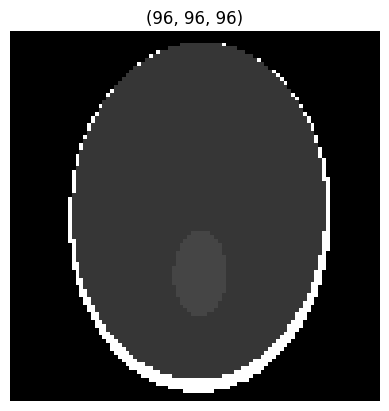

In [4]:
# middle slice along z

image = train_dataset.image
print(type(image), image.dtype)

plt.imshow(image[..., res//2], cmap='gray')
plt.title(f'{image.shape}')
plt.axis('off')

## DataModule

The provided datamodule only needs a training image to train and validate. If no special validation dataset is provided, the training dataset will be copied and changed to *non-training*, expecting the datasets to be derived from `ABCDataset`. 

*Non-training implies that the input coordinates will be shifted to the midpoint of the training coordinates.*

In [5]:
datamodule = inr.GenericDataModule(batch_size=None,
                                   num_workers=8, 
                                   use_worker_init_fn=True,
                                   train=train_dataset, 
                                   val=val_dataset, # not necessary
                                   )

# Model

There are 2 key parts to an implicit neural representation: 
1. A lifting operation that encodes data at each position in a higher-dimensional space
2. A multilayer perceptron (MLP) that maps the positional encoding to the signal

## Positional Encoding

[Tancik et al. 2020](https://arxiv.org/abs/2006.10739) found that a Gaussian encoder works well generally and demoed this in the complex 3D case. 

In [6]:
posenc = inr.GaussianPosEnc(d_input=3, # dimensionality of input ie (x,y,z)
                            embed_sz=256, # number of features to lift to
                            scale=2. # scaling factor of the gaussian
                            )

# Loss

A system is provided for custom loss functions for constraint via regularization using the following base class: 

```python
class ABCLoss(ABC, nn.Module):
    def __init__(self, loss_type, d_input: int, fncs: List[nn.Module] = [nn.MSELoss()], regularizers: List[nn.Module]=[], **kwargs):
        super().__init__()
        assert len(fncs) > 0, 'Specify at least one loss function'
        self.fncs = fncs
        self.loss_type = loss_type  # type of loss
        self.d_input = d_input  # dimension of input (x) to model
        self.sample_inds = []  # indexing values if data contains multiple samples per image
        self.regularizers = regularizers

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        loss = 0
        for fnc in self.fncs:
            loss += fnc(pred,target)
        
        reg_val = 0
        for reg in self.regularizers:
            reg_val += reg(pred)

        return loss + reg_val
    
    @abstractmethod
    def set_params(self) -> None:
        pass
    
    @abstractmethod
    def reconstruct_params(self) -> Mapping[str, np.ndarray]:
        pass

    @abstractmethod
    def prepare_input(self) -> Mapping[str, torch.Tensor]:
        pass

    @abstractmethod
    def prepare_output(self) -> Mapping[str, torch.Tensor]:
        pass
```

In [7]:
# define loss subclass

from typing import Mapping


from numpy import ndarray
from torch._tensor import Tensor


class myINRLoss(inr.ABCLoss):
    def set_params(self, *args, **kwargs):
        '''
        Set additional optimization parameters for loss, i.e., clean reconstruction
        '''
        return
    
    def reconstruct_params(self, image_shape, outputs, **other) -> Mapping[str, ndarray]:
        '''
        If added additional parameters, reconstruct them here 
        '''
        return {**other}
    
    def prepare_input(self,  x: torch.Tensor, y: torch.Tensor, **other) -> Mapping[str, Tensor]:
        xi = x.clone()
        yi = inr.make_complex(y.clone())
        yi = torch.view_as_real(yi) if torch.is_complex(yi) else yi
        return {'x': xi, 'y': yi, **other}
    
    def prepare_output(self,  y_hat: torch.Tensor, y: torch.Tensor, **other) -> Mapping[str, Tensor]:
        return {'pred': y_hat, 'target': y, **other}

## Constraints

These callables enforce properties over the model output that are fed as input to the regularizer. 

For example, a constraint on the magnitude of a complex-valued output to be less than or equal to 1 would look like: 

In [8]:
constr = inr.ComplexMagnitudeConstraint(magnitude=1.)

## Regularization

These callables enforce regularization over the model's output. 

For example, an $L_2$ regularization over the constraint defined above would look like: 

In [9]:
reg = inr.L2Regularizer(dim=None, 
                        weight=1e-4, 
                        constraints=[constr]
                        )

*Disclaimer: using this regularizer is for demo purposes only and will regularize away from the optimum, i.e., the magnitude of the complex-valued image should not be less than or equal to 1.*

Now, compose the custom loss function... 

In [10]:
# compose loss function

loss_fn = myINRLoss('mse', # loss type can be anything
                    regularizers=[reg], 
                    fncs=[inr.MSELoss()],
                    )

## MLP

Models can inherit from the NeuralImplicit base class: 

```python
class NeuralImplicit(ABC, pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.val_outputs = []
		self.scores = None
  
	def on_validation_start(self):
		self.val_outputs = []
		self.scores = None
		
	@abstractmethod
	def reconstruct(self):
		pass
	
	@abstractmethod
	def compute_metrics(self):
		pass
```

Derived classes should implement reconstruction (called externally by logger to reshape back to image dimension) and metric computation (called every iteration to compute loss and save state). 

The provided general neural implicit MLP implementation performs basic reconstruction given the corresponding indices from the dataset and the target and prediction values, reshaping the arrays back to the image shape from dataset. The loss, min, max, and stddev of the target and prediction are automatically computed for comparison and additional callables to compute metrics of the form `metric(pred, target)` can be added in a list. 

*Computation*: Since the dimensionality of the domain is $96^3 * 3 = 884,736 * 3$, we ideally need just as many parameters. For 256-width layers, this would mean 15,552 layers needed. However, the image has underlying structure and positional encoding is intended to highlight periodic structure to ease computation so we can get away with a much smaller network. 

In [11]:
MLP = inr.NeuralImplicitMLP(
    lr=1e-3, # learning rate
    posenc=posenc, # positional encoding
    n_features=256, # input dimension
    n_layers=16, # network depth
    n_output=2,  # complex 2-channel
    
    ###
    loss_fn=loss_fn, # loss function
    act_fn=nn.LeakyReLU(), # activation function
    output_fn=None, # no output activation -> unbounded output
    ###
    
    optimizer=torch.optim.Adam,
    metrics=[inr.NRMSELoss()] # metrics to track besides loss, min, max
    )

# Logging

With Lightning, we can define an image logging callback to log images, CSVs, etc. during training and validation. 

The provided image logging implementation saves images with metrics at the end of validation. 

In [12]:
phase_transf = inr.PhaseTransform(cmap='gray', vmin=-3.14, vmax=3.14)
mag_transf = inr.MagnitudeTransform(cmap='gray')
view_transfs = [phase_transf, mag_transf]

img_logger = inr.NeuralImplicitImageLogger(view_transforms=view_transfs, # callables to transform output for viewing, i.e., phase and magnitude for complex-valued images
                                        save_freq=10, # how often to save images
                                        best_only=True, # only save best images
                                       )

# Training

In [13]:
logger = CSVLogger(save_dir='logs/shepp', 
                   name='shepp1', 
                   version=1)
bar = TQDMProgressBar(refresh_rate=1000)

trainer = pl.Trainer(max_epochs=10, 
                     log_every_n_steps=1, 
                     benchmark=True,
                     accumulate_grad_batches=2,
                     logger=logger,
                     callbacks=[img_logger, bar], 
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model=MLP, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name       | Type           | Params
----------------------------------------------
0 | posenc     | GaussianPosEnc | 1.0 K 
1 | loss_fn    | myINRLoss      | 0     
2 | act_fn     | LeakyReLU      | 0     
3 | base_model | Sequential     | 1.1 M 
----------------------------------------------
1.1 M     Trainable params
1.0 K     Non-trainable params
1.1 M     Total params
4.216     Total estimated model params size (MB)
/home/zstoebs/anaconda3/envs/nerf/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/shepp/shepp1/version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


The results below show that the NRMSE decreased after only 10 epochs and some structure in the prediction is starting to appear. However, as noted above, the loss regularizes away from the optimum. 

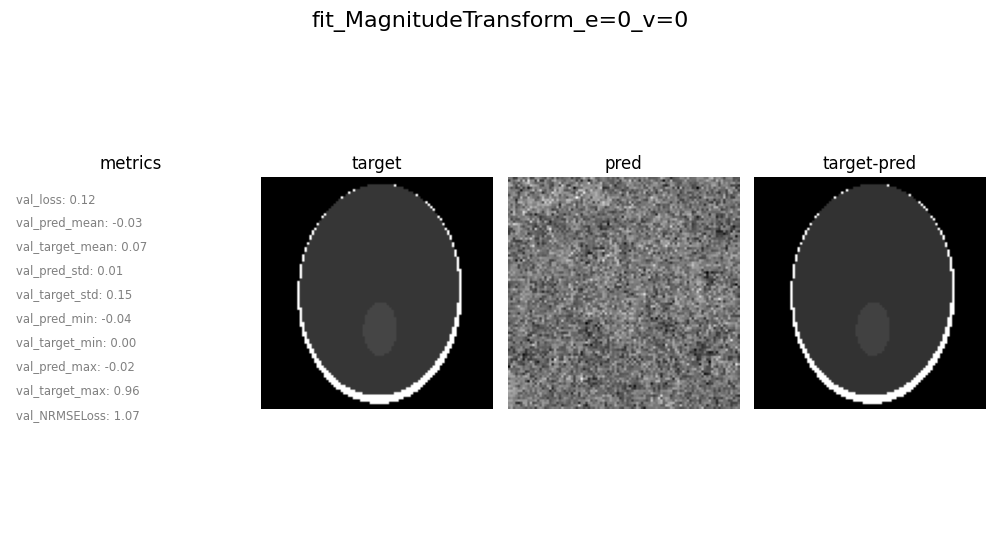

In [16]:
Image(filename='assets/shepp/fit_MagnitudeTransform_e=0_v=0.png')

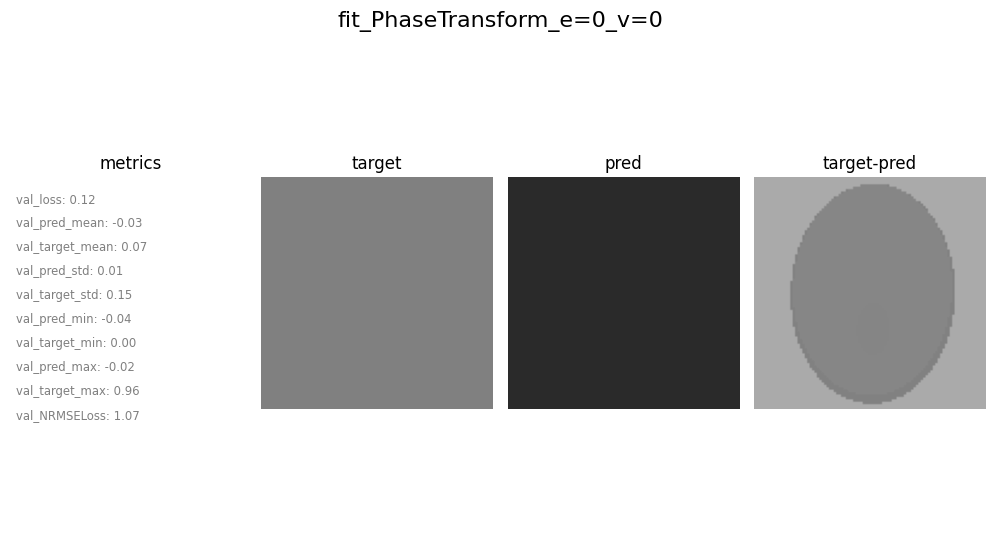

In [17]:
Image(filename='assets/shepp/fit_PhaseTransform_e=0_v=0.png')

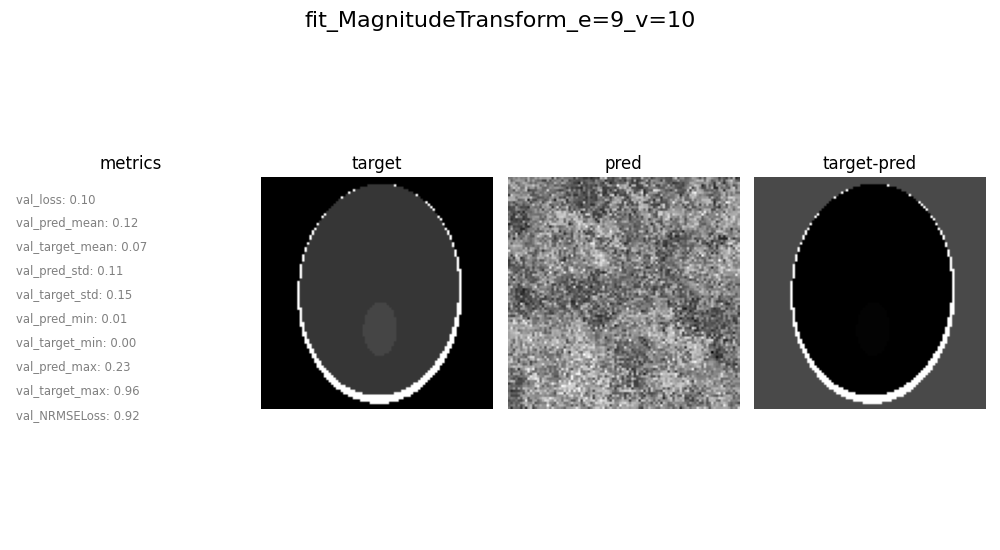

In [14]:
Image(filename='assets/shepp/fit_MagnitudeTransform_e=9_v=10.png')

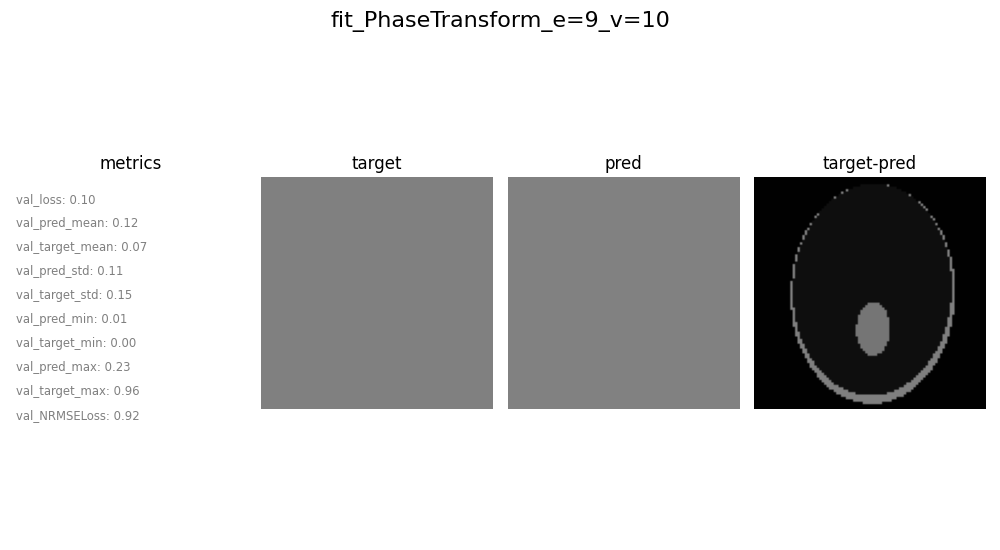

In [15]:
Image(filename='assets/shepp/fit_PhaseTransform_e=9_v=10.png')